In [2]:
import pandas as pd
import glob
import os
from nltk.corpus import stopwords


In [1]:
df = spark.read.parquet("/home/ymusic7/metro_restaurants/balanced_reviews.parquet")

In [3]:
#time change of 
review_counts = df.groupBy("keyword").count()
review_counts.show()


+-------------------+------+
|            keyword| count|
+-------------------+------+
|japanese restaurant|211226|
| chinese restaurant|211226|
+-------------------+------+



In [6]:
print(stopwords.words('english')[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [3]:
import pandas as pd
import nltk
from pyspark.sql.functions import col, lower, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer
from pyspark.sql import SparkSession

# Clean the 'text' column (remove special characters, URLs, etc.)
df_cleaned = df.withColumn("cleaned_text", 
                          regexp_replace(col("text"), r'[^a-zA-Z\s]', '').alias('cleaned_text'))

# Tokenize the text into words
tokenizer = Tokenizer(inputCol="cleaned_text", outputCol="words")
df_tokenized = tokenizer.transform(df_cleaned)

# Remove stopwords using NLTK's list
stop_words = stopwords.words('english')

# Remove stopwords from tokenized words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words", stopWords=stop_words)
df_filtered = remover.transform(df_tokenized)

# Show the resulting filtered words (after stopwords are removed)
df_filtered.select("filtered_words").show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|filtered_words                                                                                                                                                                                                              

In [9]:
# Filter for Japanese and Chinese restaurants based on `keyword`
japanese_restaurants = df_filtered.filter(col("keyword") == "japanese restaurant")
chinese_restaurants = df_filtered.filter(col("keyword") == "chinese restaurant")


In [13]:
# Show columns for Japanese restaurants
japanese_restaurants.columns

# Show columns for Chinese restaurants
chinese_restaurants.columns


['name',
 'lat',
 'lon',
 'text',
 'date',
 'score',
 'keyword',
 'addr',
 'language',
 'cleaned_text',
 'words',
 'filtered_words',
 'month_year']

In [14]:
# Show columns for Chinese restaurants
chinese_restaurants.columns

['name',
 'lat',
 'lon',
 'text',
 'date',
 'score',
 'keyword',
 'addr',
 'language',
 'cleaned_text',
 'words',
 'filtered_words',
 'month_year']

In [15]:
from pyspark.sql.functions import when, col

# Create mention columns based on keywords in the 'text' column (you can customize this)
japanese_restaurants = japanese_restaurants.withColumn(
    "chinese_mention", when(col("text").contains("chinese"), 1).otherwise(0)
)

japanese_restaurants = japanese_restaurants.withColumn(
    "japanese_mention", when(col("text").contains("japanese"), 1).otherwise(0)
)

japanese_restaurants = japanese_restaurants.withColumn(
    "asian_mention", when(col("text").contains("asian"), 1).otherwise(0)
)

chinese_restaurants = chinese_restaurants.withColumn(
    "chinese_mention", when(col("text").contains("chinese"), 1).otherwise(0)
)

chinese_restaurants = chinese_restaurants.withColumn(
    "japanese_mention", when(col("text").contains("japanese"), 1).otherwise(0)
)

chinese_restaurants = chinese_restaurants.withColumn(
    "asian_mention", when(col("text").contains("asian"), 1).otherwise(0)
)


In [16]:
from pyspark.sql.functions import date_format

# Add a "month-year" column for aggregation
japanese_restaurants = japanese_restaurants.withColumn("month_year", date_format(col("date"), "yyyy-MM"))
chinese_restaurants = chinese_restaurants.withColumn("month_year", date_format(col("date"), "yyyy-MM"))

# Aggregate mentions and calculate proportions for Japanese restaurants
japanese_trends = japanese_restaurants.groupBy("month_year").agg(
    sum("chinese_mention").alias("Chinese_mentions"),
    sum("japanese_mention").alias("Japanese_mentions"),
    sum("asian_mention").alias("Asian_mentions"),
    count("*").alias("total_reviews")
)

japanese_trends = japanese_trends.withColumn(
    "Chinese_proportion", (col("Chinese_mentions") / col("total_reviews")) * 100
).withColumn(
    "Japanese_proportion", (col("Japanese_mentions") / col("total_reviews")) * 100
).withColumn(
    "Asian_proportion", (col("Asian_mentions") / col("total_reviews")) * 100
)

# Repeat for Chinese restaurants
chinese_trends = chinese_restaurants.groupBy("month_year").agg(
    sum("chinese_mention").alias("Chinese_mentions"),
    sum("japanese_mention").alias("Japanese_mentions"),
    sum("asian_mention").alias("Asian_mentions"),
    count("*").alias("total_reviews")
)

chinese_trends = chinese_trends.withColumn(
    "Chinese_proportion", (col("Chinese_mentions") / col("total_reviews")) * 100
).withColumn(
    "Japanese_proportion", (col("Japanese_mentions") / col("total_reviews")) * 100
).withColumn(
    "Asian_proportion", (col("Asian_mentions") / col("total_reviews")) * 100
)


In [17]:
# Convert to Pandas for visualization
japanese_trends_pd = japanese_trends.toPandas().sort_values("month_year")
chinese_trends_pd = chinese_trends.toPandas().sort_values("month_year")


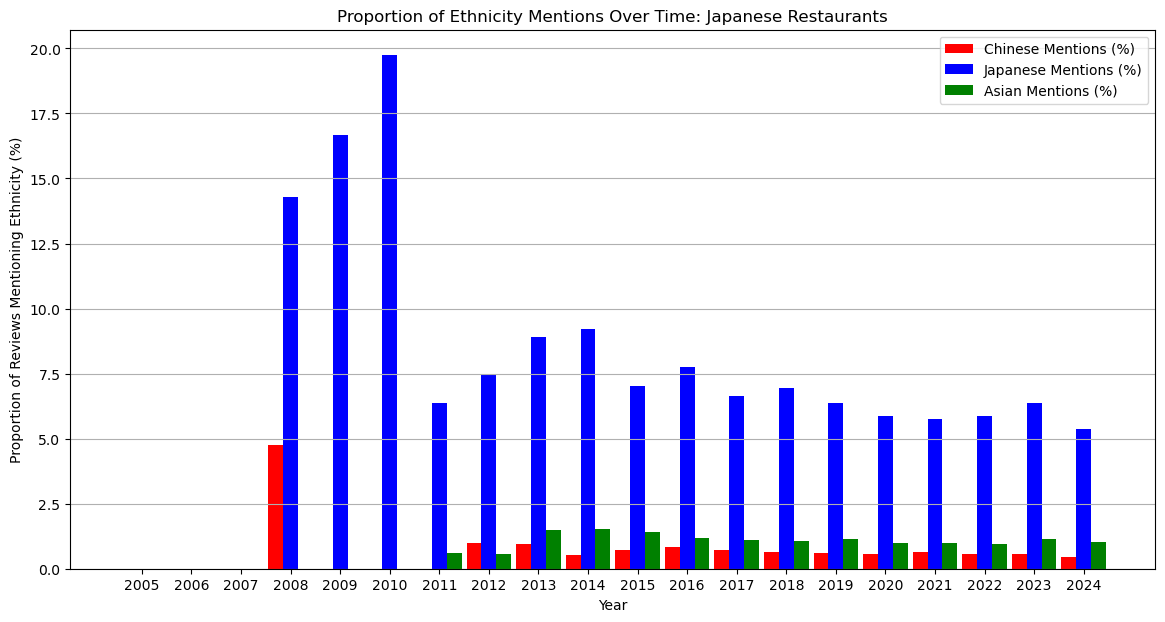

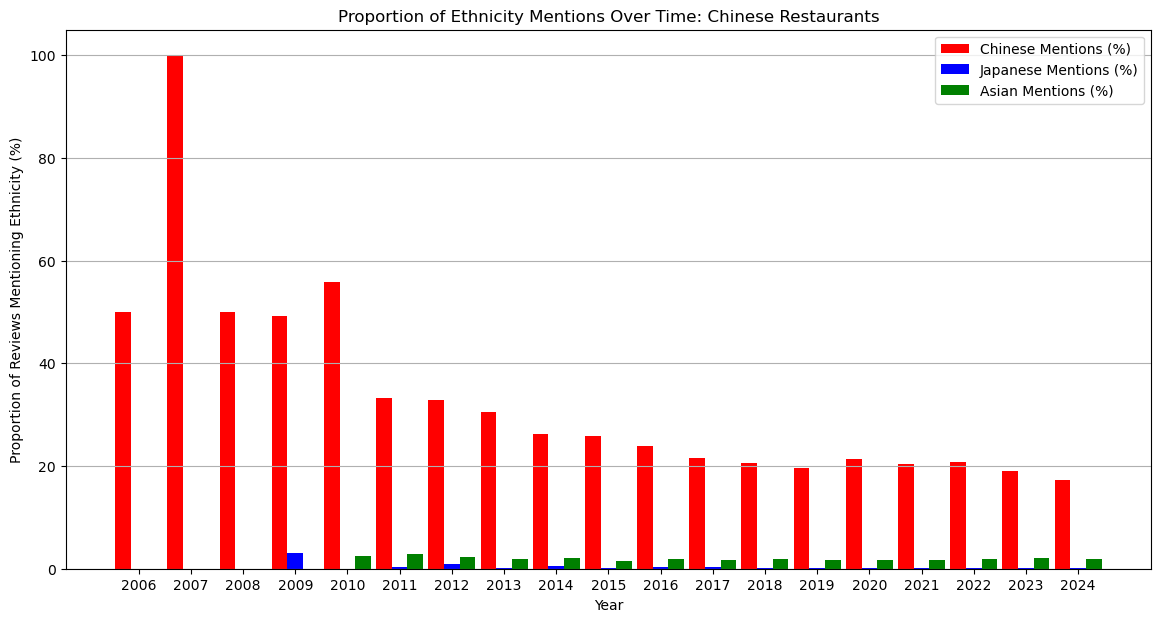

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Convert "month_year" to datetime for better grouping
japanese_trends_pd["month_year"] = pd.to_datetime(japanese_trends_pd["month_year"])
chinese_trends_pd["month_year"] = pd.to_datetime(chinese_trends_pd["month_year"])

# Extract only the year for x-axis labels
japanese_trends_pd["year"] = japanese_trends_pd["month_year"].dt.year
chinese_trends_pd["year"] = chinese_trends_pd["month_year"].dt.year

# Aggregate by year for bar graph
japanese_yearly = japanese_trends_pd.groupby("year").mean()
chinese_yearly = chinese_trends_pd.groupby("year").mean()

# Plot for Japanese restaurants
plt.figure(figsize=(14, 7))
width = 0.3  # Bar width
x = np.arange(len(japanese_yearly.index))  # X-axis positions

plt.bar(x - width, japanese_yearly["Chinese_proportion"], width, label="Chinese Mentions (%)", color="red")
plt.bar(x, japanese_yearly["Japanese_proportion"], width, label="Japanese Mentions (%)", color="blue")
plt.bar(x + width, japanese_yearly["Asian_proportion"], width, label="Asian Mentions (%)", color="green")

plt.title("Proportion of Ethnicity Mentions Over Time: Japanese Restaurants")
plt.xlabel("Year")
plt.ylabel("Proportion of Reviews Mentioning Ethnicity (%)")
plt.xticks(x, japanese_yearly.index, rotation=0)  # Display only years
plt.legend()
plt.grid(axis="y")
plt.show()

# Plot for Chinese restaurants
plt.figure(figsize=(14, 7))
x = np.arange(len(chinese_yearly.index))  # X-axis positions

plt.bar(x - width, chinese_yearly["Chinese_proportion"], width, label="Chinese Mentions (%)", color="red")
plt.bar(x, chinese_yearly["Japanese_proportion"], width, label="Japanese Mentions (%)", color="blue")
plt.bar(x + width, chinese_yearly["Asian_proportion"], width, label="Asian Mentions (%)", color="green")

plt.title("Proportion of Ethnicity Mentions Over Time: Chinese Restaurants")
plt.xlabel("Year")
plt.ylabel("Proportion of Reviews Mentioning Ethnicity (%)")
plt.xticks(x, chinese_yearly.index, rotation=0)  # Display only years
plt.legend()
plt.grid(axis="y")
plt.show()


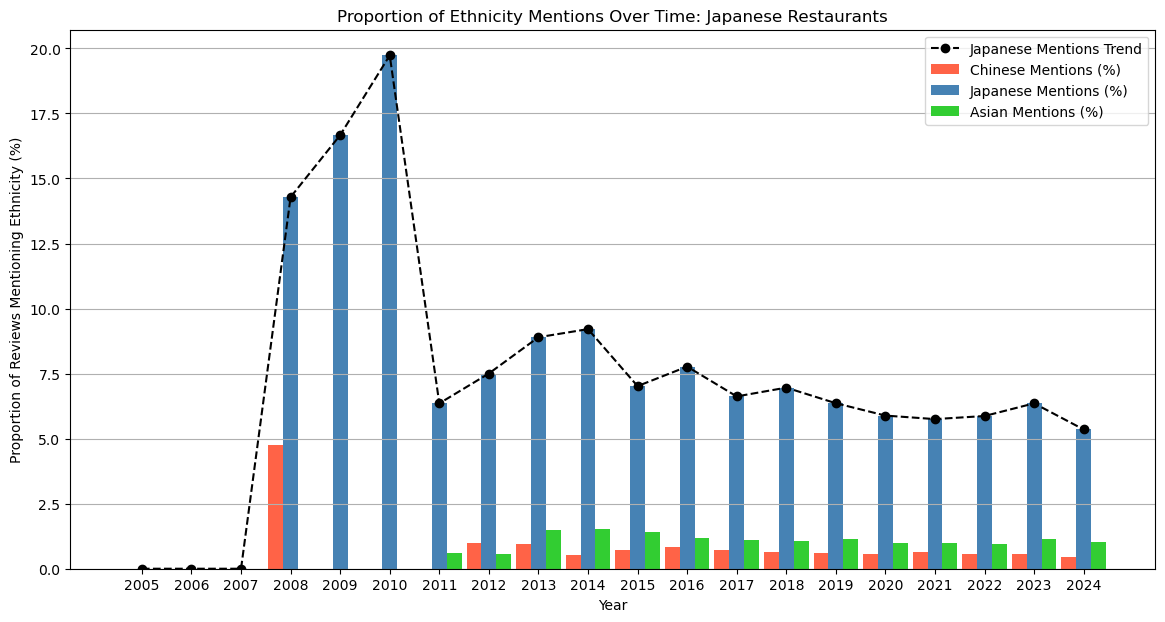

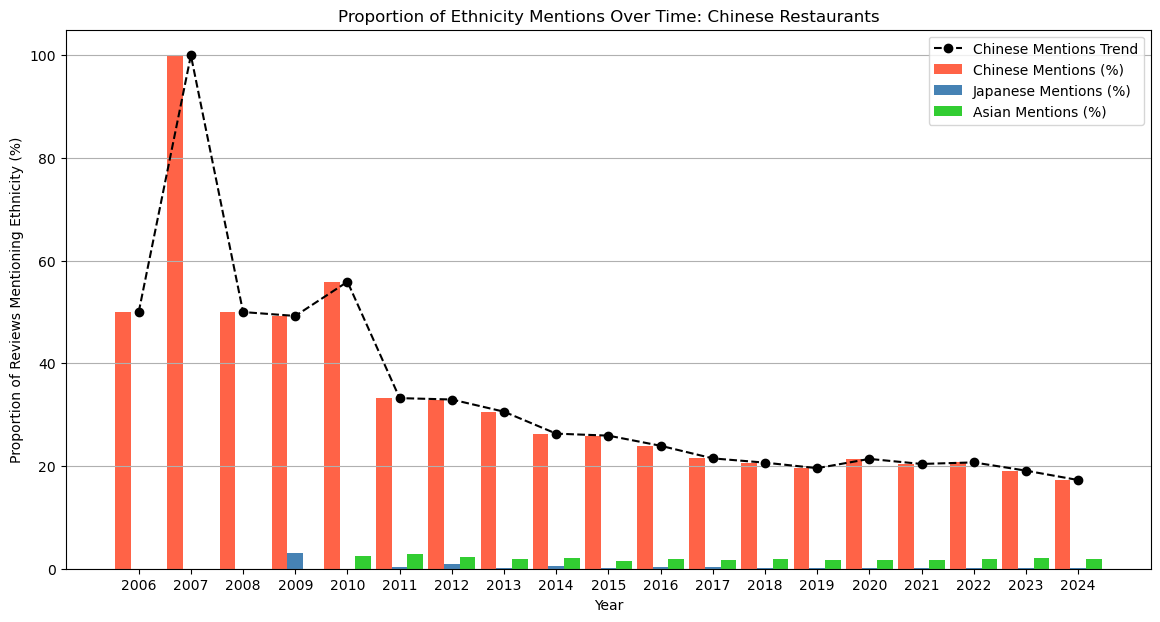

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Define custom colors
bar_colors = {"Chinese": "#FF6347", "Japanese": "#4682B4", "Asian": "#32CD32"}  # Tomato, SteelBlue, LimeGreen
line_colors = {"Japanese_trend": "black", "Chinese_trend": "black"}  # Black trend lines

# Japanese Restaurant Plot
plt.figure(figsize=(14, 7))
x = np.arange(len(japanese_yearly.index))  # X-axis positions
width = 0.3  # Bar width

# Plot bars for Japanese restaurant mentions
plt.bar(x - width, japanese_yearly["Chinese_proportion"], width, label="Chinese Mentions (%)", color=bar_colors["Chinese"])
plt.bar(x, japanese_yearly["Japanese_proportion"], width, label="Japanese Mentions (%)", color=bar_colors["Japanese"])
plt.bar(x + width, japanese_yearly["Asian_proportion"], width, label="Asian Mentions (%)", color=bar_colors["Asian"])

# Add a line for Japanese mentions trend
plt.plot(
    x, japanese_yearly["Japanese_proportion"], color=line_colors["Japanese_trend"], linestyle="--", marker="o",
    label="Japanese Mentions Trend"
)

# Format plot
plt.title("Proportion of Ethnicity Mentions Over Time: Japanese Restaurants")
plt.xlabel("Year")
plt.ylabel("Proportion of Reviews Mentioning Ethnicity (%)")
plt.xticks(x, japanese_yearly.index, rotation=0)  # Display only years
plt.legend()
plt.grid(axis="y")
plt.show()

# Chinese Restaurant Plot
plt.figure(figsize=(14, 7))
x = np.arange(len(chinese_yearly.index))  # X-axis positions

# Plot bars for Chinese restaurant mentions
plt.bar(x - width, chinese_yearly["Chinese_proportion"], width, label="Chinese Mentions (%)", color=bar_colors["Chinese"])
plt.bar(x, chinese_yearly["Japanese_proportion"], width, label="Japanese Mentions (%)", color=bar_colors["Japanese"])
plt.bar(x + width, chinese_yearly["Asian_proportion"], width, label="Asian Mentions (%)", color=bar_colors["Asian"])

# Add a line for Chinese mentions trend
plt.plot(
    x, chinese_yearly["Chinese_proportion"], color=line_colors["Chinese_trend"], linestyle="--", marker="o",
    label="Chinese Mentions Trend"
)

# Format plot
plt.title("Proportion of Ethnicity Mentions Over Time: Chinese Restaurants")
plt.xlabel("Year")
plt.ylabel("Proportion of Reviews Mentioning Ethnicity (%)")
plt.xticks(x, chinese_yearly.index, rotation=0)  # Display only years
plt.legend()
plt.grid(axis="y")
plt.show()


In [33]:
# Set a threshold for minimum number of reviews
min_reviews = 100

# Filter out years with fewer than the threshold reviews
japanese_yearly = japanese_yearly[japanese_yearly["total_reviews"] >= min_reviews]
chinese_yearly = chinese_yearly[chinese_yearly["total_reviews"] >= min_reviews]


In [31]:
# Add total reviews for context to both datasets
japanese_yearly["total_reviews"] = japanese_trends_pd.groupby("year")["total_reviews"].mean()
chinese_yearly["total_reviews"] = chinese_trends_pd.groupby("year")["total_reviews"].mean()


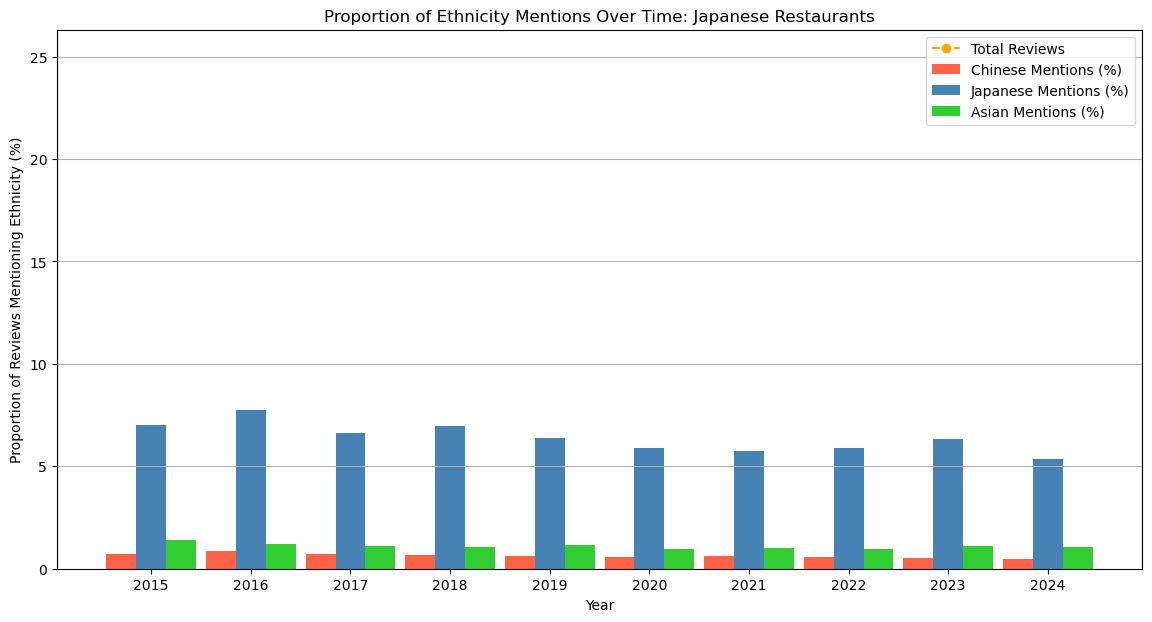

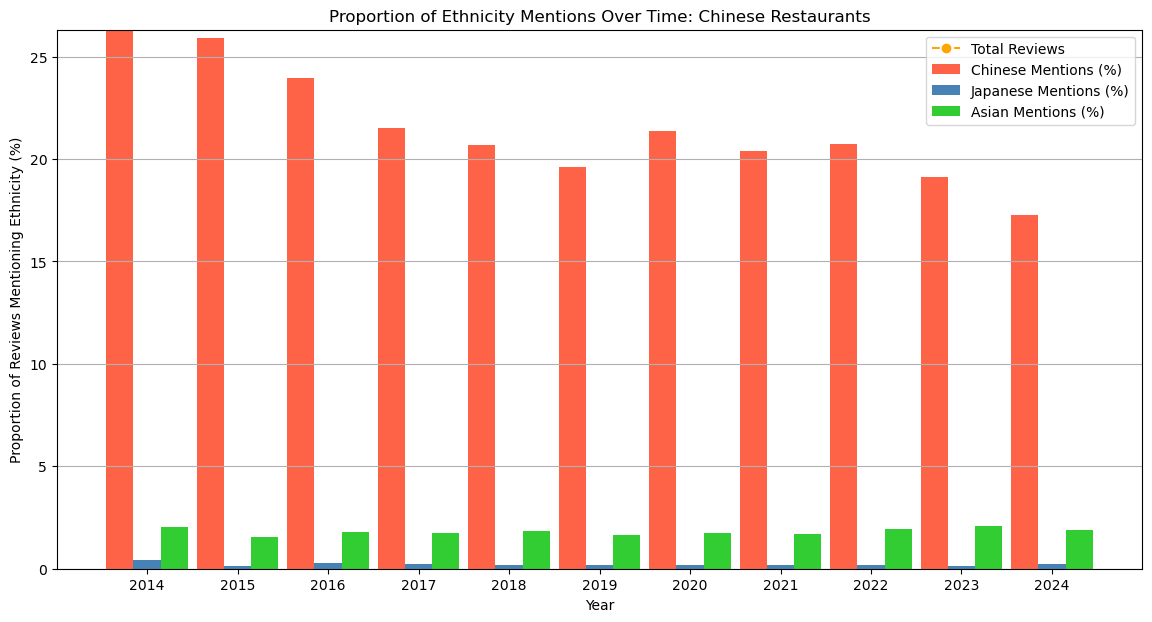

In [34]:
# Set a common Y-axis limit
y_max = max(
    japanese_yearly[["Chinese_proportion", "Japanese_proportion", "Asian_proportion"]].max().max(),
    chinese_yearly[["Chinese_proportion", "Japanese_proportion", "Asian_proportion"]].max().max()
)

# Japanese Restaurants Plot
plt.figure(figsize=(14, 7))
x = np.arange(len(japanese_yearly.index))  # X-axis positions
width = 0.3  # Bar width

# Plot bars for Japanese restaurant mentions
plt.bar(x - width, japanese_yearly["Chinese_proportion"], width, label="Chinese Mentions (%)", color=bar_colors["Chinese"])
plt.bar(x, japanese_yearly["Japanese_proportion"], width, label="Japanese Mentions (%)", color=bar_colors["Japanese"])
plt.bar(x + width, japanese_yearly["Asian_proportion"], width, label="Asian Mentions (%)", color=bar_colors["Asian"])

# Add total reviews as a line
plt.plot(
    x, japanese_yearly["total_reviews"], color="orange", linestyle="--", marker="o", label="Total Reviews"
)

# Format plot
plt.ylim(0, y_max)  # Set consistent Y-axis limit
plt.title("Proportion of Ethnicity Mentions Over Time: Japanese Restaurants")
plt.xlabel("Year")
plt.ylabel("Proportion of Reviews Mentioning Ethnicity (%)")
plt.xticks(x, japanese_yearly.index, rotation=0)
plt.legend()
plt.grid(axis="y")
plt.show()

# Chinese Restaurants Plot
plt.figure(figsize=(14, 7))
x = np.arange(len(chinese_yearly.index))  # X-axis positions

# Plot bars for Chinese restaurant mentions
plt.bar(x - width, chinese_yearly["Chinese_proportion"], width, label="Chinese Mentions (%)", color=bar_colors["Chinese"])
plt.bar(x, chinese_yearly["Japanese_proportion"], width, label="Japanese Mentions (%)", color=bar_colors["Japanese"])
plt.bar(x + width, chinese_yearly["Asian_proportion"], width, label="Asian Mentions (%)", color=bar_colors["Asian"])

# Add total reviews as a line
plt.plot(
    x, chinese_yearly["total_reviews"], color="orange", linestyle="--", marker="o", label="Total Reviews"
)

# Format plot
plt.ylim(0, y_max)  # Set consistent Y-axis limit
plt.title("Proportion of Ethnicity Mentions Over Time: Chinese Restaurants")
plt.xlabel("Year")
plt.ylabel("Proportion of Reviews Mentioning Ethnicity (%)")
plt.xticks(x, chinese_yearly.index, rotation=0)
plt.legend()
plt.grid(axis="y")
plt.show()


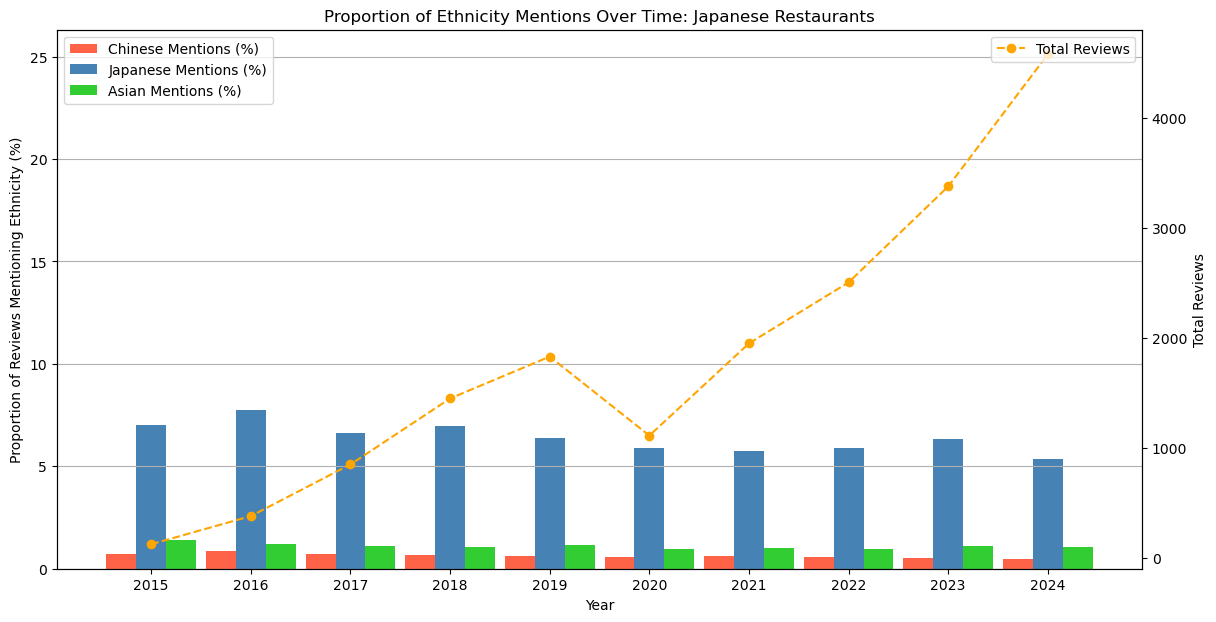

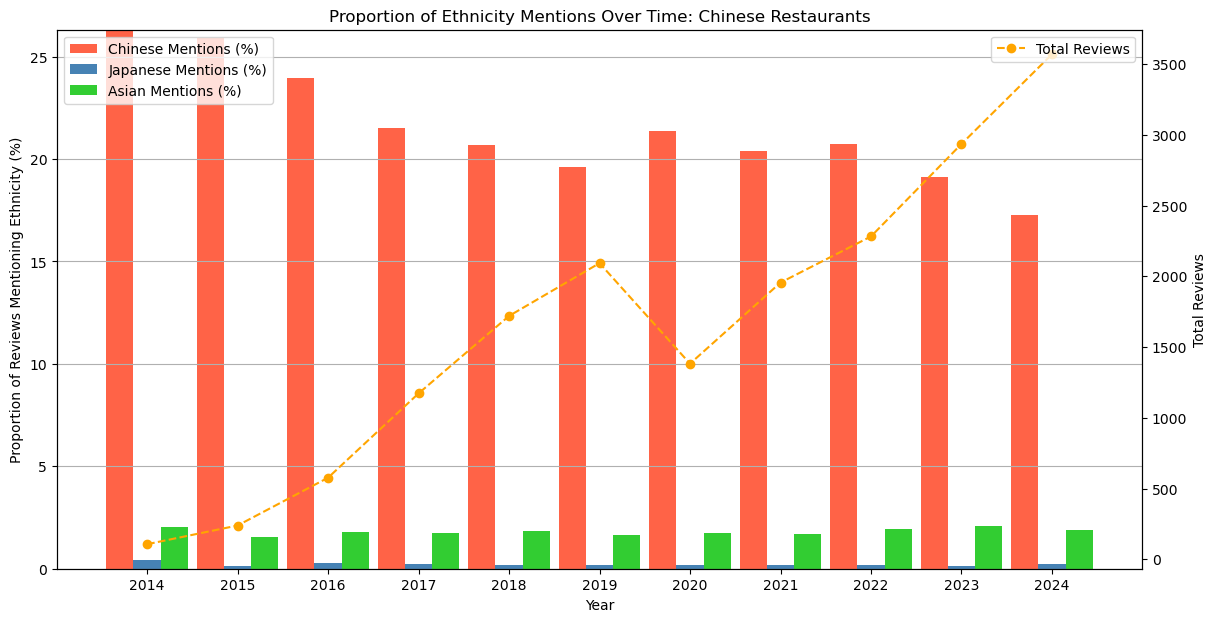

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Set custom colors
bar_colors = {"Chinese": "#FF6347", "Japanese": "#4682B4", "Asian": "#32CD32"}  # Tomato, SteelBlue, LimeGreen

# Japanese Restaurants Plot
fig, ax1 = plt.subplots(figsize=(14, 7))

x = np.arange(len(japanese_yearly.index))  # X-axis positions
width = 0.3  # Bar width

# Bar plot for proportions
ax1.bar(x - width, japanese_yearly["Chinese_proportion"], width, label="Chinese Mentions (%)", color=bar_colors["Chinese"])
ax1.bar(x, japanese_yearly["Japanese_proportion"], width, label="Japanese Mentions (%)", color=bar_colors["Japanese"])
ax1.bar(x + width, japanese_yearly["Asian_proportion"], width, label="Asian Mentions (%)", color=bar_colors["Asian"])

# Set the primary Y-axis for proportions
ax1.set_ylabel("Proportion of Reviews Mentioning Ethnicity (%)")
ax1.set_ylim(0, y_max)  # Standardize Y-axis limits
ax1.set_xlabel("Year")
ax1.set_xticks(x)
ax1.set_xticklabels(japanese_yearly.index, rotation=0)

# Add grid and legend for the bar data
ax1.grid(axis="y")
ax1.legend(loc="upper left")

# Create a secondary Y-axis for total reviews
ax2 = ax1.twinx()
ax2.plot(x, japanese_yearly["total_reviews"], color="orange", linestyle="--", marker="o", label="Total Reviews")
ax2.set_ylabel("Total Reviews")
ax2.legend(loc="upper right")

# Add title
plt.title("Proportion of Ethnicity Mentions Over Time: Japanese Restaurants")
plt.show()

# Chinese Restaurants Plot
fig, ax1 = plt.subplots(figsize=(14, 7))

x = np.arange(len(chinese_yearly.index))  # X-axis positions

# Bar plot for proportions
ax1.bar(x - width, chinese_yearly["Chinese_proportion"], width, label="Chinese Mentions (%)", color=bar_colors["Chinese"])
ax1.bar(x, chinese_yearly["Japanese_proportion"], width, label="Japanese Mentions (%)", color=bar_colors["Japanese"])
ax1.bar(x + width, chinese_yearly["Asian_proportion"], width, label="Asian Mentions (%)", color=bar_colors["Asian"])

# Set the primary Y-axis for proportions
ax1.set_ylabel("Proportion of Reviews Mentioning Ethnicity (%)")
ax1.set_ylim(0, y_max)  # Standardize Y-axis limits
ax1.set_xlabel("Year")
ax1.set_xticks(x)
ax1.set_xticklabels(chinese_yearly.index, rotation=0)

# Add grid and legend for the bar data
ax1.grid(axis="y")
ax1.legend(loc="upper left")

# Create a secondary Y-axis for total reviews
ax2 = ax1.twinx()
ax2.plot(x, chinese_yearly["total_reviews"], color="orange", linestyle="--", marker="o", label="Total Reviews")
ax2.set_ylabel("Total Reviews")
ax2.legend(loc="upper right")

# Add title
plt.title("Proportion of Ethnicity Mentions Over Time: Chinese Restaurants")
plt.show()


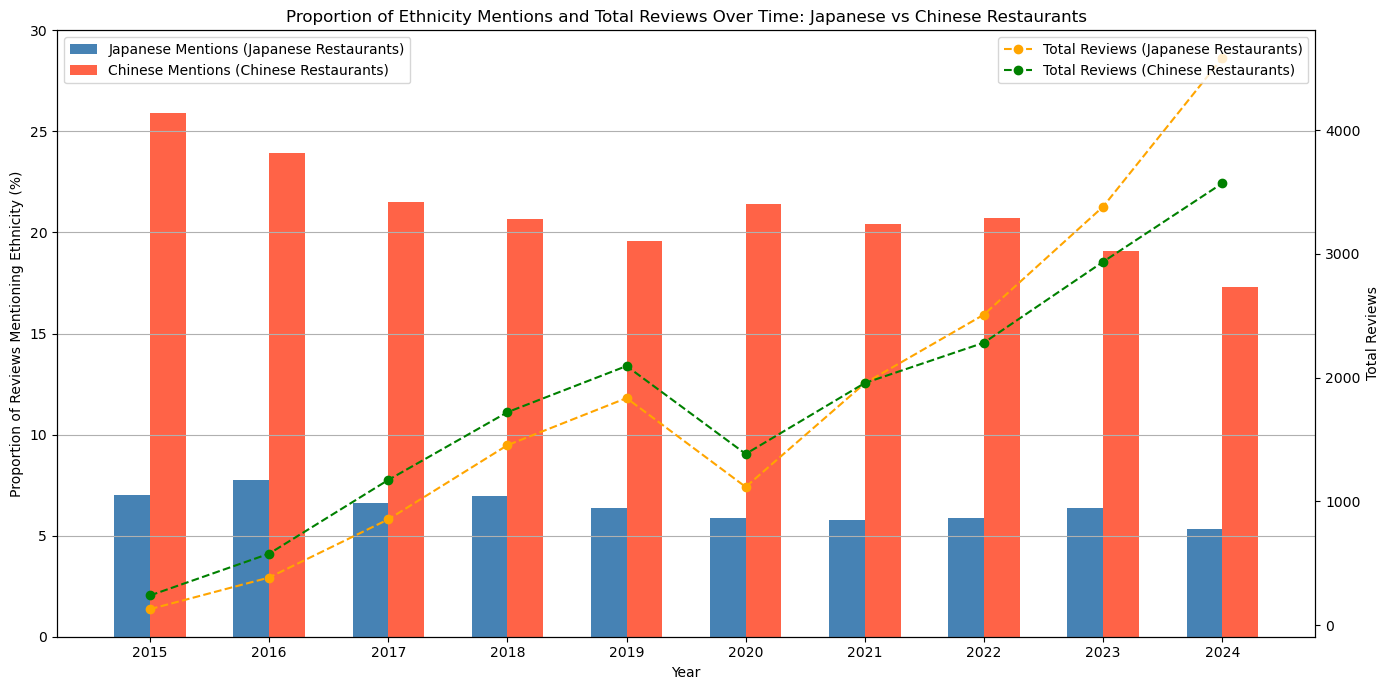

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Set custom colors
bar_colors = {"Japanese": "#4682B4", "Chinese": "#FF6347"}  # SteelBlue for Japanese, Tomato for Chinese
line_colors = {"Japanese": "orange", "Chinese": "green"}  # Orange and Green for total reviews

# Ensure the years are aligned between the two datasets
common_years = set(japanese_yearly.index).intersection(chinese_yearly.index)
japanese_yearly = japanese_yearly[japanese_yearly.index.isin(common_years)]
chinese_yearly = chinese_yearly[chinese_yearly.index.isin(common_years)]

x = np.arange(len(common_years))  # X-axis positions
width = 0.3  # Bar width

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(14, 7))

# Bar plots for proportions
ax1.bar(x - width / 2, japanese_yearly["Japanese_proportion"], width, label="Japanese Mentions (Japanese Restaurants)", color=bar_colors["Japanese"])
ax1.bar(x + width / 2, chinese_yearly["Chinese_proportion"], width, label="Chinese Mentions (Chinese Restaurants)", color=bar_colors["Chinese"])

# Format the primary y-axis (for proportions)
ax1.set_ylabel("Proportion of Reviews Mentioning Ethnicity (%)")
ax1.set_ylim(0, 30)  # Adjust y-axis range for proportions
ax1.set_xlabel("Year")
ax1.set_xticks(x)
ax1.set_xticklabels(sorted(common_years), rotation=0)  # Use sorted years for consistency
ax1.legend(loc="upper left")
ax1.grid(axis="y")

# Add a secondary y-axis for total reviews
ax2 = ax1.twinx()
ax2.plot(x, japanese_yearly["total_reviews"], color=line_colors["Japanese"], linestyle="--", marker="o", label="Total Reviews (Japanese Restaurants)")
ax2.plot(x, chinese_yearly["total_reviews"], color=line_colors["Chinese"], linestyle="--", marker="o", label="Total Reviews (Chinese Restaurants)")
ax2.set_ylabel("Total Reviews")
ax2.legend(loc="upper right")

# Add a title
plt.title("Proportion of Ethnicity Mentions and Total Reviews Over Time: Japanese vs Chinese Restaurants")
plt.tight_layout()

# Show the plot
plt.show()


In [18]:
from textblob import TextBlob
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

# Define UDF for sentiment analysis
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

sentiment_udf = udf(get_sentiment, FloatType())
df_with_sentiment = df_filtered.withColumn("sentiment_score", sentiment_udf("cleaned_text"))
df_with_sentiment.select("cleaned_text", "sentiment_score").show(truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [40]:
from pyspark.ml.feature import CountVectorizer

vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features")
cv_model = vectorizer.fit(df_filtered)
df_vectorized = cv_model.transform(df_filtered)

# Inspect vectorized features
df_vectorized.select("features").show(truncate=False)




24/12/13 23:04:33 WARN DAGScheduler: Broadcasting large task binary with size 1862.9 KiB
24/12/13 23:04:33 WARN DAGScheduler: Broadcasting large task binary with size 1862.9 KiB
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                        

In [19]:
df.printSchema()


root
 |-- name: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- text: string (nullable = true)
 |-- date: string (nullable = true)
 |-- score: integer (nullable = true)
 |-- keyword: string (nullable = true)
 |-- addr: string (nullable = true)
 |-- language: string (nullable = true)



In [47]:
chinese_trends = chinese_restaurants.groupBy("month_year").agg(
    sum("chinese_mention").alias("Chinese_mentions"),
    sum("japanese_mention").alias("Japanese_mentions"),
    sum("asian_mention").alias("Asian_mentions"),
    count("*").alias("total_reviews"),
    avg("sentiment_score").alias("avg_sentiment")  # Include average sentiment
)

chinese_trends = chinese_trends.withColumn(
    "Chinese_proportion", (col("Chinese_mentions") / col("total_reviews")) * 100
).withColumn(
    "Japanese_proportion", (col("Japanese_mentions") / col("total_reviews")) * 100
).withColumn(
    "Asian_proportion", (col("Asian_mentions") / col("total_reviews")) * 100
)


In [48]:
japanese_trends_pd = japanese_trends.toPandas()
chinese_trends_pd = chinese_trends.toPandas()


In [50]:
correlation_japanese = japanese_trends_pd[["avg_sentiment", "Japanese_proportion", "Chinese_proportion", "Asian_proportion"]].corr()
print("Correlation for Japanese Restaurants:")
print(correlation_japanese)


Correlation for Japanese Restaurants:
                     avg_sentiment  Japanese_proportion  Chinese_proportion  \
avg_sentiment             1.000000            -0.054378            0.091496   
Japanese_proportion      -0.054378             1.000000           -0.047639   
Chinese_proportion        0.091496            -0.047639            1.000000   
Asian_proportion          0.117167            -0.089138           -0.029246   

                     Asian_proportion  
avg_sentiment                0.117167  
Japanese_proportion         -0.089138  
Chinese_proportion          -0.029246  
Asian_proportion             1.000000  


In [51]:
correlation_chinese = chinese_trends_pd[["avg_sentiment", "Japanese_proportion", "Chinese_proportion", "Asian_proportion"]].corr()
print("Correlation for Chinese Restaurants:")
print(correlation_chinese)


Correlation for Chinese Restaurants:
                     avg_sentiment  Japanese_proportion  Chinese_proportion  \
avg_sentiment             1.000000             0.138789           -0.129020   
Japanese_proportion       0.138789             1.000000           -0.002343   
Chinese_proportion       -0.129020            -0.002343            1.000000   
Asian_proportion          0.180534            -0.054242           -0.250186   

                     Asian_proportion  
avg_sentiment                0.180534  
Japanese_proportion         -0.054242  
Chinese_proportion          -0.250186  
Asian_proportion             1.000000  
